Create dataframe for file and its label.

Essentials imports.

In [1]:
import pandas as pd # for data manipulation
import matplotlib.pyplot as plt # for image plotting
import os # to get the path of image
import cv2 # for image manipulation
import random as rn # random number generator
from PIL import Image # python image library for image manipulation
from skimage import feature # for image feature extraction
from sklearn.preprocessing import LabelEncoder # to encode the labels of data
import pickle # to save the model

Taking a glance at the data.

In [2]:
labels = pd.read_csv("datasets/labels.csv", index_col=0)
labels = labels.reset_index()

labels.head()


,file_name,disease_type
0,Normal-1,normal
1,Normal-2,normal
2,Normal-3,normal
3,Normal-4,normal
4,Normal-5,normal


Suffling and resetting the index.

In [3]:
labels = labels.sample(frac=1).reset_index(drop=True)
labels.head()

,file_name,disease_type
0,COVID-3500,covid
1,COVID-2748,covid
2,Normal-202,normal
3,COVID-3496,covid
4,COVID-2490,covid


Create a function to display image refrence to its index and return the file_name and disease_type.

In [4]:
def show_image(index):
    """
    Displays an image from the dataset with respect to the given index and returns the subspecies|.
    """
    file_name = labels[labels.index==index].file_name.values[0]
    disease_type = labels[labels.index==index].disease_type.values[0]
    root="datasets/images/"
    img_path = os.path.join(root, file_name) + ".png"
    img = cv2.imread(img_path)
    img = cv2.resize(img, (100, 100), interpolation = cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img, cmap='gray')
    plt.show()
    return file_name, disease_type
    

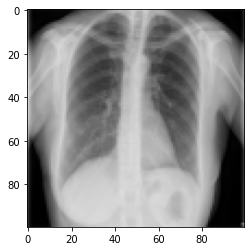

('COVID-3500', 'covid')

In [5]:
show_image(0)

Generate the hog features.

In [6]:
def hog_data_extractor(img_name):
    root="datasets/images/"
    img_path = os.path.join(root, img_name)
    img_data = cv2.imread(img_path)
    img_data = cv2.resize(img_data, (100, 100), interpolation = cv2.INTER_AREA)
    img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
    hog_data = feature.hog(img_data)/255.0
    return hog_data

In [7]:
hog_data_extractor("Normal-827.png")

array([9.86534805e-04, 1.58958544e-04, 1.42869000e-05, ...,
       0.00000000e+00, 5.47894364e-05, 4.96806678e-04])

Save file_name and subspecies to array.

In [8]:

img_name_all = labels.file_name.values
disease_types_all = labels.disease_type.values
img_name_all

array(['COVID-3500', 'COVID-2748', 'Normal-202', ..., 'COVID-1128',
       'COVID-948', 'Normal-2938'], dtype=object)

Store the hog features in to X_train and X_test.

In [9]:
X_train = []
X_test = []
label_train = []
label_test = []

train_percent = 0.7
data_length = len(img_name_all)
train_index = int(data_length*train_percent)

In [10]:

for i in range(train_index):
    try:
        hog_data = hog_data_extractor(img_name_all[i]+".png")
        X_train.append(hog_data)
        label_train.append(disease_types_all[i])
    except:
        print(img_name_all[i], disease_types_all[i])
        print("Error")

In [11]:
for i in range(train_index, data_length):
    try:
        hog_data = hog_data_extractor(img_name_all[i]+".png")
        X_test.append(hog_data)
        label_test.append(disease_types_all[i])
    except:
        print(img_name_all[i], disease_types_all[i])
        print("Error")

Use label encoder to encode the disease type where **covid** is encoded as *0* and **normal** is encoded as *1*.

In [12]:
le = LabelEncoder()
y_train = le.fit_transform(label_train)
y_test = le.fit_transform(label_test)
print(f"{label_train[0]} is encoded as {y_train[0]}")

covid is encoded as 0


Create a variable to store the label in the sequence of "covid" and "normal" respectively so they represent 0 and 1 the elements in the array.

In [13]:
disease_types = ['covid', 'normal']

Create a Linear SVM classifier and train it.

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

In [15]:
svc = SVC(C=1000, kernel='poly', degree=4, tol=1e-5)
svc.fit(X_train, y_train)
svc_score = svc.score(X_test, y_test)
print("svc_score: ", svc_score)

svc_score:  0.930841121495327


Score and Cross validation result of the model.

In [16]:
# # filter all the warnings
# import warnings
# warnings.filterwarnings("ignore")

# # 10-fold cross validation
# kfold = KFold(n_splits=10, random_state=9, shuffle=True)
# cv_results = cross_val_score(svc, X_train, y_train, cv=kfold, scoring='accuracy')
# print(cv_results)
# print(np.mean(cv_results))

In [18]:
# print(cv_results.mean(), cv_results.std())

Classification Reoport:

In [19]:
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93      1071
           1       0.95      0.91      0.93      1069

    accuracy                           0.93      2140
   macro avg       0.93      0.93      0.93      2140
weighted avg       0.93      0.93      0.93      2140



In [29]:
c_matrix = confusion_matrix(y_test, svc.predict(X_test))
print(c_matrix)

[[1017   54]
 [  94  975]]


Create a function to predict the disease.

In [30]:
def disease_predict(img_name):
    root="datasets/images/"
    img_path = os.path.join(root, img_name) + ".png"
    ip_image = Image.open(img_path)
    prd_image_data = hog_data_extractor(img_name+".png")
    disease_type_predict = svc.predict(prd_image_data.reshape(1, -1))
    
    title =f"Original: {labels.disease_type[labels.file_name == img_name].values[0]} \n Predicted: {disease_types[disease_type_predict[0]]}"
    plt.figure()
    plt.imshow(ip_image, cmap='gray')
    plt.title(title)

Randomly take a sample of the data and predict the disease.

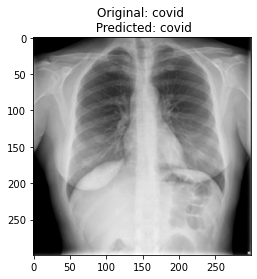

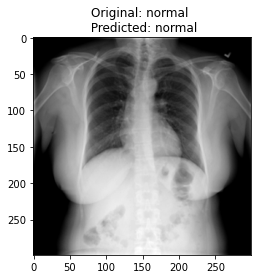

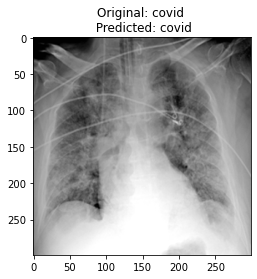

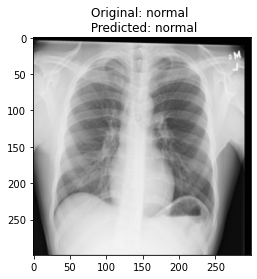

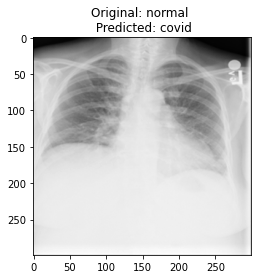

In [31]:
ip_img_files = labels.file_name.values.tolist()[train_index:] # taking only the test images
rnd = rn.randint(0, len(ip_img_files)-1)
predicted_diseases = [disease_predict(file_name) for file_name in ip_img_files[rnd:rnd+5]] # predicted_diseases doesnt contains anything, used only to stop veberse

Saving model

In [32]:
# pickle.dump(svc, open('./models/svc.pkl','wb'))

# Random Forest Classifier

In [34]:
from sklearn.ensemble import RandomForestClassifier
Random_classifier = RandomForestClassifier(n_estimators = 30, criterion = 'entropy', random_state = 0)
Random_classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=30, random_state=0)

In [35]:
randomForest_score = Random_classifier.score(X_test, y_test)
print("RandomForest_score: ", randomForest_score)

RandomForest_score:  0.8453271028037384


In [36]:
# # filter all the warnings
# import warnings
# warnings.filterwarnings("ignore")

# # 10-fold cross validation
# kfold = KFold(n_splits=10, random_state=9, shuffle=True)
# Random_clf_results = cross_val_score(Random_classifier, X_train, y_train, cv=kfold, scoring='accuracy')
# print(Random_clf_results)

In [38]:
y_pred = Random_classifier.predict(X_test)
# print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

In [39]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
acc = accuracy_score(y_test, y_pred)
print(f"The accuracy of the Random Forest model is {acc*100}%")

[[962 109]
 [222 847]]
The accuracy of the Random Forest model is 84.53271028037383%


In [40]:
print(classification_report(y_test, Random_classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      1071
           1       0.89      0.79      0.84      1069

    accuracy                           0.85      2140
   macro avg       0.85      0.85      0.84      2140
weighted avg       0.85      0.85      0.84      2140



# Logistic regression

In [41]:
from sklearn.linear_model import LogisticRegression 
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train) #Train the classifer i=on the training set

LogisticRegression(random_state=0)

In [43]:
import numpy as np
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0 0]
 [1 1]
 [0 0]
 ...
 [0 0]
 [0 0]
 [0 1]]


In [44]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
acc = accuracy_score(y_test, y_pred)
print(f"The accuracy of the Random Forest model is {acc*100}%")

[[1060   11]
 [ 648  421]]
The accuracy of the Random Forest model is 69.2056074766355%


In [45]:
print(classification_report(y_test, classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.62      0.99      0.76      1071
           1       0.97      0.39      0.56      1069

    accuracy                           0.69      2140
   macro avg       0.80      0.69      0.66      2140
weighted avg       0.80      0.69      0.66      2140

